This program uses a feed forward neural network, which is settled in machine learning.


In [30]:
# https://youtu.be/tKM5d8Ll1k0
"""
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

'\nDataset from: https://www.kaggle.com/rakannimer/air-passengers\nInternational Airline Passengers prediction problem.\nThis is a problem where, given a year and a month, the task is to predict \nthe number of international airline passengers in units of 1,000. \nThe data ranges from January 1949 to December 1960, or 12 years, with 144 observations.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

In [3]:
# Machine learning libaries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D

# Data Preparation

In [4]:
# load the dataset, but only imports second column
# dataframe = pd.read_csv('data/AirPassengers.csv', usecols=[1])

dataframe = pd.read_csv('data/AirPassengers.csv')
dataframe


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
# converts column month from int64 to datetime
dataframe['Month'] = pd.to_datetime(dataframe['Month'])

In [6]:
# sets month column as index of dataframe
dataframe.set_index('Month', inplace=True) 

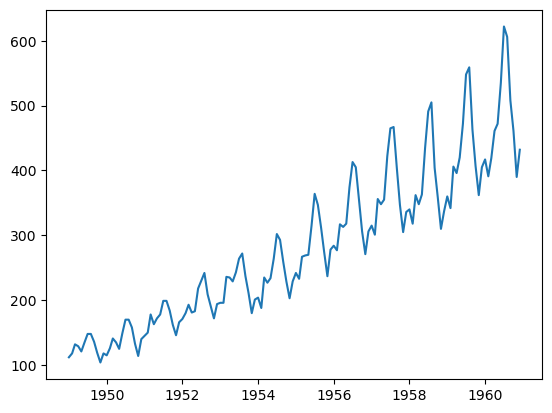

In [7]:
# Plot data
plt.plot(dataframe)

# Data Exploration

In [8]:
dataframe['year'] = dataframe.index.year
dataframe['month'] = dataframe.index.month

<Axes: xlabel='year', ylabel='Passengers'>

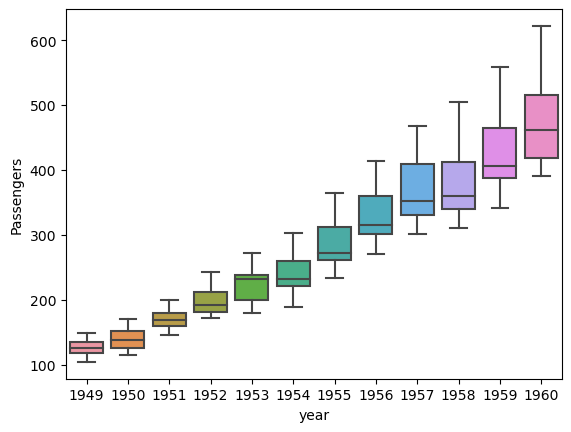

In [9]:
#Plot yearly and monthly values as boxplot
sns.boxplot(x='year', y='Passengers', data=dataframe)


<Axes: xlabel='month', ylabel='Passengers'>

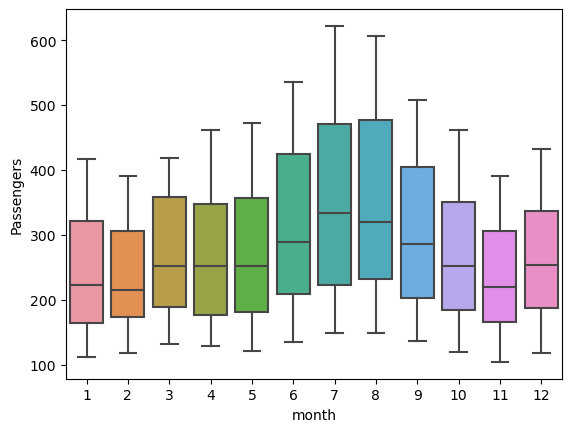

In [10]:
sns.boxplot(x='month', y='Passengers', data=dataframe)

In [11]:
dataframe

,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5
...,...,...,...
1960-08-01,606,1960,8
1960-09-01,508,1960,9
1960-10-01,461,1960,10


In [14]:
# One can extract the trends and seasonality within the data by using the following 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(dataframe['Passengers'],  
                            model ='additive')

In [ ]:
# There can be different time series types
"""
Additive time series:
Value = Base Level + Trend + Seasonality + Error
Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

"""

In [15]:
# From the imported module "seasonal_decompose" one can extract the trend, seasonal, and residual 
trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

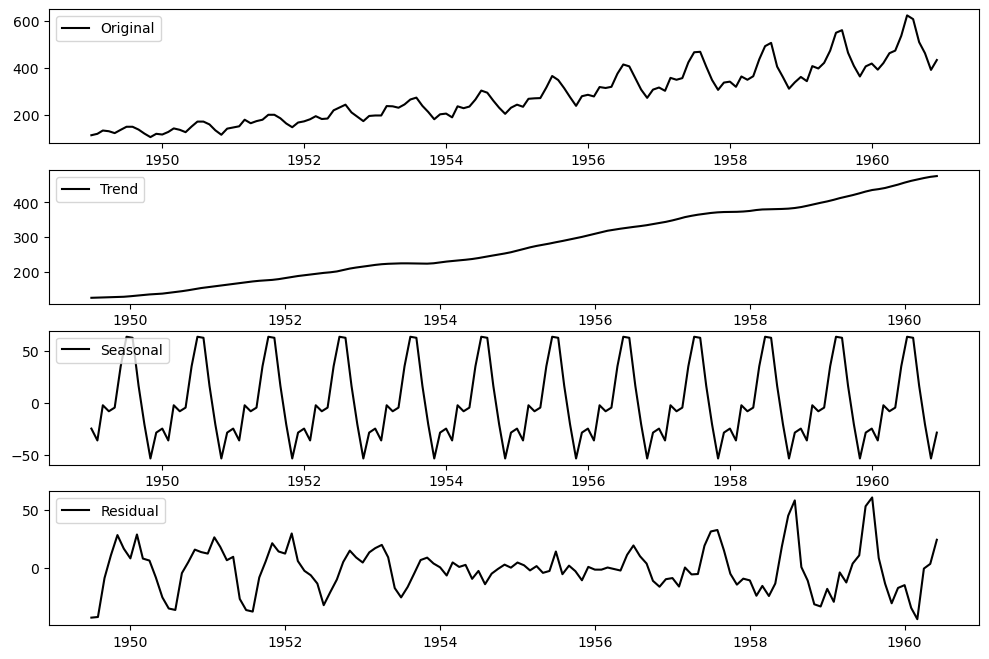

In [16]:
# Plot all Data Explorations
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(dataframe['Passengers'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

In [17]:
# Since time series data is commonly only correlated with nothing but itself,
# it is interesting to detect the degreee of autocorrelation for the dataset

""""
Autocorrelation is simply the correlation of a series with its own lags.
Plot lag on x axis and correlation on y axis
Any correlation above confidence lnes are statistically significant.

"""

'"\nAutocorrelation is simply the correlation of a series with its own lags.\nPlot lag on x axis and correlation on y axis\nAny correlation above confidence lnes are statistically significant.\n\n'

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

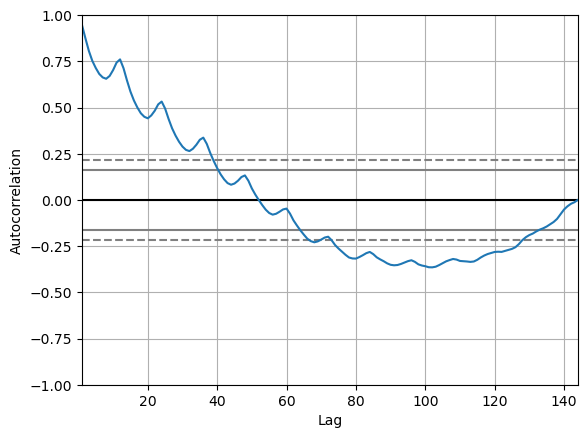

In [18]:
# Detect autocorrelation with pandas module
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dataframe.Passengers) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

In [ ]:
# In the graph one can see, that for smaller lags than 40 there is a 99% confidence of positive autocorrelation

# RNN & LTSM

In [19]:
# For machine learning values need to be between 0 and 1 
# Therefore a type change is necessary from int to float 32
dataset = dataframe['Passengers'].values
dataset = dataset.astype('float32') #COnvert values to float

In [20]:
# Reshapes array such it has dimensions (X,1)
dataset = dataset.reshape(dataset.shape[0],1)
dataset.shape

(144, 1)

In [21]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

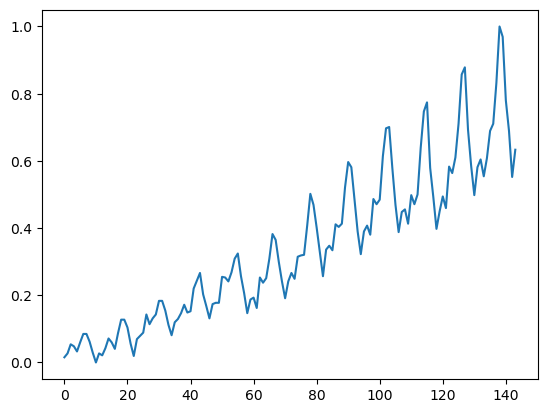

In [22]:
plt.plot(dataset)

In [23]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 66% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [24]:
""""

We cannot fit the model like we normally do for image processing where we have
X and Y. We need to sequentially input our data from the training dataset, 
such that, for example, the 5 values are taken as input to the network and 
the 6th sequential value in the train dataset is taken as the output for the network.
This way the network learns what correlations there are such that the 4 input values
result in the 6th or nth output value. 

"""

'"\n\nWe cannot fit the model like we normally do for image processing where we have\nX and Y. We need to sequentially input our data from the training dataset, \nsuch that, for example, the 5 values are taken as input to the network and \nthe 6th sequential value in the train dataset is taken as the output for the network.\nThis way the network learns what correlations there are such that the 4 input values\nresult in the 6th or nth output value. \n\n'

In [25]:
# Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
seq_size = length = 10

In [26]:
#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data


batch_size = 1
train_generator = TimeseriesGenerator(train,train,length=length,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#With length 40 it generated 55 samples, each of length 40 (by using data of length 95)

Total number of samples in the original training data =  95
Total number of samples in the generated data =  75


In [27]:
# As an example this is the first sequence that is feed into the network
# It contains 20 input values in one array and 1 output value in another array
train_generator[0]

(array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
         0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
         0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
         0.05984557, 0.04054055, 0.08687258, 0.12741312, 0.12741312]],
       dtype=float32),
 array([0.10424709], dtype=float32))

In [28]:
# Generates validation data with same procedure
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)

In [ ]:
#Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

In [ ]:
#############################################
# SimpleRNN before moving on to LSTM

# model = Sequential()
# model.add(SimpleRNN(64, input_shape=(length, num_features), activation='relu')) #12
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
# print(model.summary()) 

##################################################

In [ ]:
##########################################################
#LSTM single layer with 50 units
# model = Sequential()

# model.add(LSTM(50, input_shape=(length, num_features)))
# model.add(Dense(1))
# model.compile(optimizer = 'adam', loss='mse')
# ###############################################

In [ ]:
# ######################################################
#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, num_features)))
model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
###############################################

In [ ]:
# ######################################################
#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()

#########################################################

In [ ]:
# ######################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

# trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
# testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

# model = Sequential()
# model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
# model.add(Flatten())              #<-- we need the Flatten Layer because we get a 2D output from the Conv Layer. The Flatten layer transfroms that to a 1D vector
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()


#########################################

In [69]:
# Trains the model to the data
# Since we use TimeSeriesGenerator from Keras we do not use model.fit(...) instead we use model.fit_generator(...)          !IMPORTANT!
model.fit_generator(generator=train_generator, verbose=1, epochs=100, validation_data=validation_generator)

# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch.


Epoch 1/100
16/75 [=====>........................] - ETA: 0s - loss: 2.4752e-04 - acc: 0.0000e+00

C:\Users\PC\AppData\Local\Temp\ipykernel_11452\3905446002.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, verbose=1, epochs=100, validation_data=validation_generator)


75/75 [==============================] - 0s 5ms/step - loss: 2.7936e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0345
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 2.0928e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0345
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 2.5023e-04 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0345
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 2.4984e-04 - acc: 0.0000e+00 - val_loss: 0.0023 - val_acc: 0.0345
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 2.4456e-04 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0345
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 4.1494e-04 - acc: 0.0000e+00 - val_loss: 0.0061 - val_acc: 0.0345
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 4.0415e-04 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0345
Epoch 8/100
75/75 [====================

In [70]:
# Makes predictions on training and testing data

trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

29/29 [==============================] - 0s 2ms/step


In [71]:
# Since data is normalized between 0 and 1, we need to reverse this transformation
# use scaler.inverse_transform

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)

testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

In [73]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.62 RMSE
Test Score: 29.59 RMSE


In [76]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

array([[      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [160.89514],
       [132.80498],
       [119.48454],
       [143.42241],
       [153.42346],
       [157.99745],
       [179.01562],
       [166.28726],
       [174.81613],
       [182.66695],
       [203.60011],
       [202.33736],
       [189.99043],
       [165.6377 ],
       [146.84851],
       [169.35225],
       [173.80194],
       [184.40948],
       [198.409  ],
       [191.0238 ],
       [187.55302],
       [219.77895],
       [235.7548 ],
       [240.48064],
       [222.21472],
       [191.65361],
       [178.22302],
       [195.40367],
       [204.28452],
       [203.95473],


In [77]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict

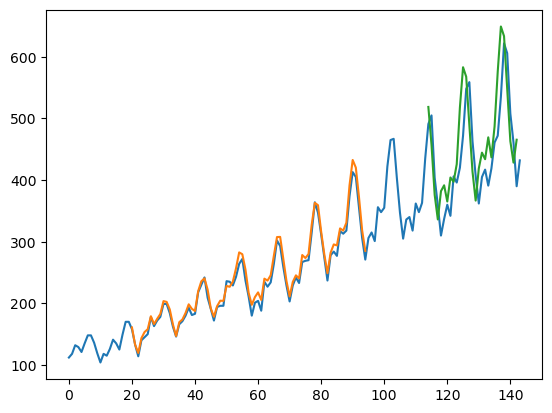

In [80]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()